### import library

In [1]:
import os
from gensim import corpora, models
from gensim.models import CoherenceModel
import gensim
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from konlpy.tag import Komoran

### load dataset
articles_essential_refined.csv 파일  
- title: 논문 이름
- author: 논문 저자
- year: 논문 발행 년도
- vol, no: 논문 권호 사항
- keyword: 논문에서 선정한 키워드
- abstract: 초록 전문    

<b>총 200건의 데이터</b>

In [2]:
dataset = pd.read_csv('./data/articles_essential_refined.csv', encoding='utf-8')
dataset

,title,author,year,vol,no,keyword,abstract
0,예술치료사 자기효능감 척도 개발 및 타당화 연구,"김 영 신 , 김동민",2019,21,21,"예술치료, 자기효능감, 예술치료사 자기효능감 척도, 타당화",본 연구에서는 예술치료사의 전문적 자기효능감을 측정할 수 있는 예술치료사 자기효능감...
1,델파이 방법을 통한 국내 재활음악치료 발전방안 연구,박환영,2019,21,21,"재활음악치료, 발전방안, 델파이","본 연구는 델파이 방법을 통하여 국내 재활분야에서 음악치료의 현재 위치를 인식하고,..."
2,음악치료사의 훈련과정에서 경험한 열등감 인식과 통찰에 대한 자문화기술지,"이 혜 민 , 소혜진",2019,21,21,"음악치료사, 치료사 훈련과정, 열등감, 자문화기술지",본 연구는 한 개인 음악치료사의 훈련과정에서 경험한 열등감 인식과 통찰을 고찰하는 ...
3,호스피스ㆍ완화의료 환자를 대상으로 한 국내ㆍ외 음악치료 연구 메타분석,"최혜진 , 황은영",2019,21,21,"호스피스ㆍ완화의료, 음악치료, 메타분석",본 연구는 메타분석을 통해 호스피스ㆍ완화의료 환자를 대상으로 한 음악치료의 전체효과...
4,수퍼바이지가 지각하는 음악치료 전문성과 수퍼비전 교육요구에 대한 합의적 질적연구,"김동민 , 정 종 현 , 소라엘 , 최지엘 , 김 영 신",2019,21,21,"음악치료사, 발달, 전문성, 수퍼비전, 수퍼바이지, 합의적 질적연구",본 연구는 수퍼바이지가 지각하는 음악치료 전문성 요인을 탐색하고 이를 발달시키기 위...
...,...,...,...,...,...,...,...
195,멜로디억양치료(Melodic Intonation Therapy)가 비유창성 실어증환...,이난복,2000,2,2,MV,본 연구는 멜로디억양치료(Melodic Intonation Therapy: MIT)...
196,음악치료에 대한 정신과 영역 전문인들의 인식도 조사,김경숙,1999,1,1,MV,본 연구의 목적은 국내 정신과 관련 전문인들의 음악치료에 대한 인식과 태도를 조사하...
197,"""Journal of Music Therapy""(1987~1998)에 수록된 논문의...",김은주,1999,1,1,MV,본 연구는 19897년부터 1998년까지의 Journal of Music Thera...
198,음악활동이 정신지체아동의 부적응행동 감소에 미치는 효과,성인영,1999,1,1,MV,본 연구의 목적은 정신지체아동의 부적응행동을 감소시켜 효과적인 학습환경과 집단생활을...


### extract nouns
Python <b>KoNLPy</b> 라이브러리를 사용해서 각 논문의 초록에 있는 단어 중 <b>명사</b>를 추출한다.  
명사를 추출하는 과정에서 <b>고유 명사를 저장한 사전</b>을 활용 (dictionary_pos.tsv)    
추출된 명사 중 명사의 <b>길이가 2이상이고 50번 이상 사용된 단어</b>로 제한

In [3]:
original_nouns = []  # 초록에 등장하는 모든 명상
target_nouns = []    # 제한 조건에 따라 추출된 일부 명사

komoran = Komoran(userdic='./data/dictionary_pos.tsv')

# 초록에 등장하는 모든 명사를 추출해서 저장
abstracts = dataset['abstract']
for idx in abstracts.index:
    nouns = komoran.nouns(abstracts.loc[idx])
    for noun in nouns:
        original_nouns.append(noun)


counter = Counter(original_nouns)
for word, frequency in counter.most_common():
    if len(word) >= 2 and frequency >= 50:
        target_nouns.append(word)

print('원래 명사의 개수: {}'.format(len(original_nouns)))
print('조건에 따라서 선택된 명사의 개수: {}'.format(len(target_nouns)))

원래 명사의 개수: 25186
조건에 따라서 선택된 명사의 개수: 85


### add column in dataset
각 초록을 선택된 명사의 리스트로 표현한다.  
명사들의 리스트를 담고 있는 column noun을 추가

In [4]:
dataset['noun'] = ""
abstracts = dataset['abstract']
for idx in abstracts.index:
    results = komoran.nouns(abstracts.loc[idx])
    nouns = []
    for noun in results:
        if noun in target_nouns:
            nouns.append(noun)
    dataset['noun'].loc[idx] = nouns

dataset

/Users/dhsong/Workspaces/Music Therapy NLP Project/Pycharm Project/venv/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,title,author,year,vol,no,keyword,abstract,noun
0,예술치료사 자기효능감 척도 개발 및 타당화 연구,"김 영 신 , 김동민",2019,21,21,"예술치료, 자기효능감, 예술치료사 자기효능감 척도, 타당화",본 연구에서는 예술치료사의 전문적 자기효능감을 측정할 수 있는 예술치료사 자기효능감...,"[연구, 측정, 척도, 개발, 활동, 측정, 척도, 척도, 문항, 대상, 요인, 분..."
1,델파이 방법을 통한 국내 재활음악치료 발전방안 연구,박환영,2019,21,21,"재활음악치료, 발전방안, 델파이","본 연구는 델파이 방법을 통하여 국내 재활분야에서 음악치료의 현재 위치를 인식하고,...","[연구, 방법, 음악치료, 인식, 음악치료, 임상, 대상, 조사, 실시, 결과, 다..."
2,음악치료사의 훈련과정에서 경험한 열등감 인식과 통찰에 대한 자문화기술지,"이 혜 민 , 소혜진",2019,21,21,"음악치료사, 치료사 훈련과정, 열등감, 자문화기술지",본 연구는 한 개인 음악치료사의 훈련과정에서 경험한 열등감 인식과 통찰을 고찰하는 ...,"[연구, 개인, 음악치료사, 과정, 경험, 인식, 목적, 연구, 연구, 대상자, 경..."
3,호스피스ㆍ완화의료 환자를 대상으로 한 국내ㆍ외 음악치료 연구 메타분석,"최혜진 , 황은영",2019,21,21,"호스피스ㆍ완화의료, 음악치료, 메타분석",본 연구는 메타분석을 통해 호스피스ㆍ완화의료 환자를 대상으로 한 음악치료의 전체효과...,"[연구, 환자, 대상, 음악치료, 효과, 확인, 환자, 대상, 음악치료, 중재, 연..."
4,수퍼바이지가 지각하는 음악치료 전문성과 수퍼비전 교육요구에 대한 합의적 질적연구,"김동민 , 정 종 현 , 소라엘 , 최지엘 , 김 영 신",2019,21,21,"음악치료사, 발달, 전문성, 수퍼비전, 수퍼바이지, 합의적 질적연구",본 연구는 수퍼바이지가 지각하는 음악치료 전문성 요인을 탐색하고 이를 발달시키기 위...,"[연구, 음악치료, 요인, 발달, 교육, 경험, 음악치료사, 자료, 방법, 사용, ..."
...,...,...,...,...,...,...,...,...
195,멜로디억양치료(Melodic Intonation Therapy)가 비유창성 실어증환...,이난복,2000,2,2,MV,본 연구는 멜로디억양치료(Melodic Intonation Therapy: MIT)...,"[연구, 치료, 환자, 효과, 평균, 연구, 대상, 검사, 도구, 검사, 결과, 환..."
196,음악치료에 대한 정신과 영역 전문인들의 인식도 조사,김경숙,1999,1,1,MV,본 연구의 목적은 국내 정신과 관련 전문인들의 음악치료에 대한 인식과 태도를 조사하...,"[연구, 목적, 정신, 관련, 음악치료, 인식, 조사, 음악치료, 연구, 대상, 정..."
197,"""Journal of Music Therapy""(1987~1998)에 수록된 논문의...",김은주,1999,1,1,MV,본 연구는 19897년부터 1998년까지의 Journal of Music Thera...,"[연구, 내용, 분석, 음악치료, 연구, 유형, 변화, 연구, 연구, 내용, 분석,..."
198,음악활동이 정신지체아동의 부적응행동 감소에 미치는 효과,성인영,1999,1,1,MV,본 연구의 목적은 정신지체아동의 부적응행동을 감소시켜 효과적인 학습환경과 집단생활을...,"[연구, 목적, 정신, 아동, 행동, 감소, 효과, 음악활동, 효과, 연구, 사용,..."


### make corpus
지금까지의 작업으로 개별 논문을 초록에 포함된 주요 단어(기준에 따라서 선택된 단어)의 리스트로 표현된 상태.  
Topic Modeling을 위해서 단어를 컴퓨터가 이해할 수 있도록 사전(Dictionary) 제작.  
사전은 개별 단어와 그에 대한 인덱스 정보를 가지고 있다.  
논문을 최종적으로 사전에서의 인덱스로 표현되어야한다.  
  
<b>논문 -> 초록의 주요 단어 리스트 -> (초록의 주요 단어에 대한 인덱스, 개수) 리스트</b>

In [5]:
nouns = dataset['noun'].to_list()
dictionary = corpora.Dictionary(nouns)
corpus = [dictionary.doc2bow(noun) for noun in nouns]

print('>> SAMPLE')
print('>> index 0와 연관된 단어 {}'.format(dictionary[0]))
print('>> 첫 번째 논문에 포함된 주요 명사 리스트\n{}'.format(nouns[0]))
print('>> 변환된 첫 번째 논문\n{}'.format(corpus[0]))

>> SAMPLE
>> index 0와 연관된 단어 개발
>> 첫 번째 논문에 포함된 주요 명사 리스트
['연구', '측정', '척도', '개발', '활동', '측정', '척도', '척도', '문항', '대상', '요인', '분석', '실시', '결과', '치료', '중재', '치료', '관계', '요인', '문항', '요인', '자료', '검증', '대상', '확인', '요인', '분석', '실시', '결과', '요인', '분석', '하위', '요인', '문항', '개발', '척도', '확인', '연구', '결과', '개발', '척도', '요인', '교육', '효과', '관련', '연구', '측정', '도구']
>> 변환된 첫 번째 논문
[(0, 3), (1, 1), (2, 3), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 3), (9, 3), (10, 2), (11, 3), (12, 7), (13, 1), (14, 1), (15, 5), (16, 3), (17, 2), (18, 1), (19, 2), (20, 1), (21, 1)]


### LDA 방식의 토픽 모델링
토픽의 개수는 11개로 한다.

In [6]:
num_topics = 11
if os.path.exists('./models/ldamodel'):
    print('기존의 LDAModel을 불러옵니다.')
    ldamodel = gensim.models.ldamodel.LdaModel.load('./models/ldamodel')
else:
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, iterations=3000)
    ldamodel.save('./models/ldamodel')

기존의 LDAModel을 불러옵니다.


### 추출된 토픽 정보

In [7]:
topics = ldamodel.print_topics(num_topics=num_topics)
for topic in topics:
    print(topic)

(0, '0.078*"음악치료" + 0.077*"치료" + 0.065*"연구" + 0.042*"결과" + 0.033*"음악치료사" + 0.032*"영향" + 0.024*"경험" + 0.024*"분석" + 0.023*"자극" + 0.023*"행동"')
(1, '0.077*"스트레스" + 0.077*"노인" + 0.067*"연구" + 0.054*"차이" + 0.041*"유의미" + 0.040*"노래" + 0.039*"치료" + 0.033*"개인" + 0.033*"결과" + 0.030*"대상"')
(2, '0.060*"활동" + 0.051*"그룹" + 0.045*"음악" + 0.040*"실험" + 0.040*"연구" + 0.040*"경험" + 0.040*"차이" + 0.040*"대상" + 0.036*"검사" + 0.035*"제시"')
(3, '0.099*"집단" + 0.059*"노인" + 0.057*"반응" + 0.052*"노래" + 0.050*"실험" + 0.050*"정서" + 0.047*"연구" + 0.033*"통제" + 0.029*"결과" + 0.026*"차이"')
(4, '0.066*"집단" + 0.066*"음악치료" + 0.042*"연구" + 0.038*"검증" + 0.035*"문항" + 0.030*"검사" + 0.030*"치료" + 0.028*"영역" + 0.026*"유아" + 0.026*"도구"')
(5, '0.101*"집단" + 0.051*"연구" + 0.045*"음악" + 0.039*"실험" + 0.036*"결과" + 0.030*"아동" + 0.027*"통제" + 0.025*"유의미" + 0.025*"치료" + 0.022*"차이"')
(6, '0.096*"음악" + 0.091*"선호" + 0.052*"연구" + 0.043*"반응" + 0.040*"음악치료" + 0.040*"차이" + 0.038*"아동" + 0.038*"문항" + 0.036*"음악치료사" + 0.029*"분석"')
(7, '0.115*"연구" + 0.050*"음악" + 0.039*"결

### Visualization

In [8]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

pyLDAvis.save_html(vis, './visualize_3000.html')

vis

/Users/dhsong/Workspaces/Music Therapy NLP Project/Pycharm Project/venv/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.051097  0.030995       1        1  19.889933
9      0.015277  0.019686       2        1  16.820400
0      0.037370 -0.027908       3        1  14.447704
7      0.074987 -0.018394       4        1  11.297967
8      0.072418 -0.006424       5        1   7.698550
3     -0.150830  0.058222       6        1   7.016324
4      0.006970  0.082000       7        1   6.911352
6      0.040171 -0.086402       8        1   6.332509
2     -0.093954  0.021319       9        1   6.032918
1     -0.077728 -0.132724      10        1   3.229037
10     0.126416  0.059629      11        1   0.323313, topic_info=   Category        Freq  Term       Total  loglift  logprob
26  Default  430.000000  음악치료  430.000000  30.0000  30.0000
11  Default  724.000000    연구  724.000000  29.0000  29.0000
24  Default  116.000000    방법  116.000000  28.0000  28.0000
25  Default  120.000000    영역  120.000000  27.0000  27.0000
56  Default  433.000000    집단  433.000000  26.0000  26.0000
..      ...         ...   ...         ...      ...      ...
79  Topic11    0.179572    반응  134.364700  -0.8834  -5.2148
63  Topic11    0.179572   유의미  156.256256  -1.0344  -5.2148
55  Topic11    0.179572    정서  143.118179  -0.9465  -5.2148
59  Topic11    0.179569    통제  132.456726  -0.8691  -5.2148
13  Topic11    0.179569    자료   94.555733  -0.5321  -5.2148

[475 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
50        1  0.346807    감소
50        2  0.075864    감소
50        3  0.216755    감소
50        4  0.021675    감소
50        5  0.130053    감소
...     ...       ...   ...
21        9  0.057398    효과
21       10  0.040178    효과
45        2  0.192502  효과크기
45        4  0.469223  효과크기
45        5  0.312815  효과크기

[732 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 10, 1, 8, 9, 4, 5, 7, 3, 2, 11])

### 연도별 토픽의 변화
논문의 주제라고 판단한 결과는 확률로 나타난다. ex) 토픽 0일 확률 0.2, 토픽 1일 확률 0.8  
가장 높은 확률값을 가진 토픽을 해당 논문의 주제라고 간주하고 연도별 주제 변화 추이를 살핀다.  
토픽을 묶는 것도 허용한다.

In [9]:
years = dataset['year'].to_list()
nouns = dataset['noun'].to_list()

topic_year_freq = dict()
for t in range(num_topics):
    topic_year_freq[t] = [0] * len(set(years))

for _, (noun, year) in enumerate(zip(nouns, years)):
    topics = ldamodel.get_document_topics(dictionary.doc2bow(noun))
    topics = sorted(topics, key=lambda topic: topic[1], reverse=True)
    topic = topics[0][0]
    
    topic_year_freq[topic][year-1999] += 1

print(topic_year_freq)

{0: [0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 1, 3, 1, 3, 2, 1, 2, 3, 6, 4], 1: [0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0], 2: [0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0], 3: [0, 2, 1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], 4: [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 2, 1, 3, 1, 0, 0], 5: [1, 0, 3, 3, 2, 5, 2, 1, 2, 2, 2, 1, 1, 1, 1, 0, 1, 4, 2, 2, 1], 6: [0, 1, 0, 0, 0, 2, 3, 1, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0], 7: [1, 0, 0, 1, 0, 0, 2, 1, 2, 1, 5, 4, 1, 1, 2, 2, 1, 1, 1, 4, 2], 8: [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 0, 2, 2, 1, 1, 0, 2], 9: [0, 0, 0, 1, 2, 0, 0, 3, 2, 1, 4, 3, 2, 2, 2, 1, 1, 1, 3, 1, 3], 10: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}


In [10]:
# collapse = [(0, 3, 5), (2, 4)]
collapse = []
for c in collapse:
    topic_year_freq[c[0]] = [0] * len(set(years))
    for t in c[1:]:
        topic_year_freq[c[0]] = [a + b for a, b in zip(topic_year_freq[c[0]], topic_year_freq[t])]
        del topic_year_freq[t]

for topic, freq in topic_year_freq.items():
    print('Topic-{:2d}의 년도별 빈도수(1999-2019) : {:}\t총 빈도: {:02d}'.format(topic + 1, freq, sum(freq)))

Topic- 1의 년도별 빈도수(1999-2019) : [0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 1, 3, 1, 3, 2, 1, 2, 3, 6, 4]	총 빈도: 31
Topic- 2의 년도별 빈도수(1999-2019) : [0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0]	총 빈도: 08
Topic- 3의 년도별 빈도수(1999-2019) : [0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0]	총 빈도: 09
Topic- 4의 년도별 빈도수(1999-2019) : [0, 2, 1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]	총 빈도: 11
Topic- 5의 년도별 빈도수(1999-2019) : [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 2, 1, 3, 1, 0, 0]	총 빈도: 11
Topic- 6의 년도별 빈도수(1999-2019) : [1, 0, 3, 3, 2, 5, 2, 1, 2, 2, 2, 1, 1, 1, 1, 0, 1, 4, 2, 2, 1]	총 빈도: 37
Topic- 7의 년도별 빈도수(1999-2019) : [0, 1, 0, 0, 0, 2, 3, 1, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]	총 빈도: 12
Topic- 8의 년도별 빈도수(1999-2019) : [1, 0, 0, 1, 0, 0, 2, 1, 2, 1, 5, 4, 1, 1, 2, 2, 1, 1, 1, 4, 2]	총 빈도: 32
Topic- 9의 년도별 빈도수(1999-2019) : [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 0, 2, 2, 1, 1, 0, 2]	총 빈도: 16
Topic-10의 년도별 빈도수(1999-2019) : [0, 0, 0, 1, 2, 0, 0, 3, 2, 1, 4,

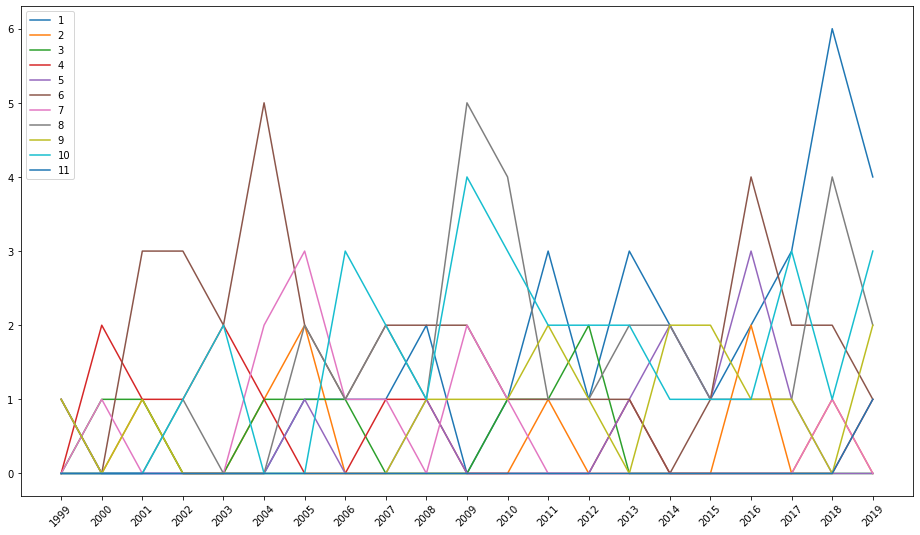

In [11]:
import matplotlib.pyplot as plt

x_data = list(range(1999, 2020))
x_data = list(map(lambda data: str(data), x_data))

legends = list()

plt.figure(figsize=(16, 9))

for topic, year_freq in topic_year_freq.items():
    y_data = year_freq    
    plt.plot(x_data, y_data)
    legends.append(str(topic + 1))
    
plt.legend(legends)
plt.xticks(rotation=45)

plt.show()